In [1]:
import numpy as np
import shapely
import cv2
import os
import supervision as sv
import matplotlib.pyplot as plt

## Data Exploration and Understanding
Dataset statistics 

How many instances of solar panels are present in the dataset?

Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)

What method was used to compute the area (in meters) for a single instance?

What is the mean area and standard deviation?

Plot the histogram of areas. What do you observe?


In [2]:
images_folder="image_chips_native"
print(len(os.listdir(images_folder)))
labels_folder="labels\labels_native"
print(len(os.listdir(labels_folder)))

2542
2542


so there are some images with no labels(there were 2553 files in image_folder, i have deleted the files with no labels below so now they are equal)

no. of instances of solar panels:  29625


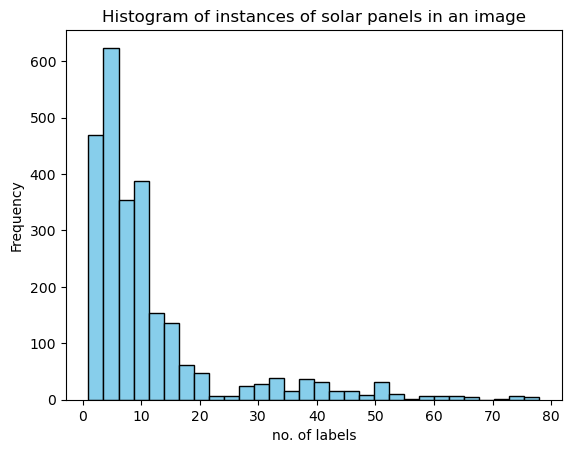

In [3]:
#the number of labels in each label file is an instance of a solar panel, so we should sum up the no. of rows in each label file
instances_panels=0
images_folder="image_chips_native"
image_files=os.listdir(images_folder)
labels_folder="labels\labels_native"
labels_count={}
for f in image_files:
    label_file = os.path.splitext(f)[0] + '.txt'
    label_path = os.path.join(labels_folder, label_file)

    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            num_labels = len(file.readlines())  # Count the number of lines (labels)
            
    else:
        # If no label file exists, assume 0 labels
        num_labels = 0
    instances_panels+=num_labels
    labels_count[f]=num_labels
print("no. of instances of solar panels: ",instances_panels)
plt.hist(list(labels_count.values()), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of instances of solar panels in an image')
plt.xlabel('no. of labels')
plt.ylabel('Frequency')
plt.show()

In [4]:
for i,j in list(labels_count.items())[1546:1556]:
    print(i," has ",j," labels")

solarpanels_native_2__x0_8750_y0_6485_dxdy_416.tif  has  2  labels
solarpanels_native_2__x0_8755_y0_4434_dxdy_416.tif  has  3  labels
solarpanels_native_2__x0_8763_y0_4503_dxdy_416.tif  has  3  labels
solarpanels_native_2__x0_876_y0_8772_dxdy_416.tif  has  4  labels
solarpanels_native_2__x0_880_y0_10344_dxdy_416.tif  has  41  labels
solarpanels_native_2__x0_885_y0_10446_dxdy_416.tif  has  58  labels
solarpanels_native_2__x0_8920_y0_3164_dxdy_416.tif  has  3  labels
solarpanels_native_2__x0_8943_y0_4161_dxdy_416.tif  has  3  labels
solarpanels_native_2__x0_894_y0_10378_dxdy_416.tif  has  46  labels
solarpanels_native_2__x0_8966_y0_4023_dxdy_416.tif  has  3  labels


Mean area: 191.52 square meters
Standard deviation of area: 630.70 square meters


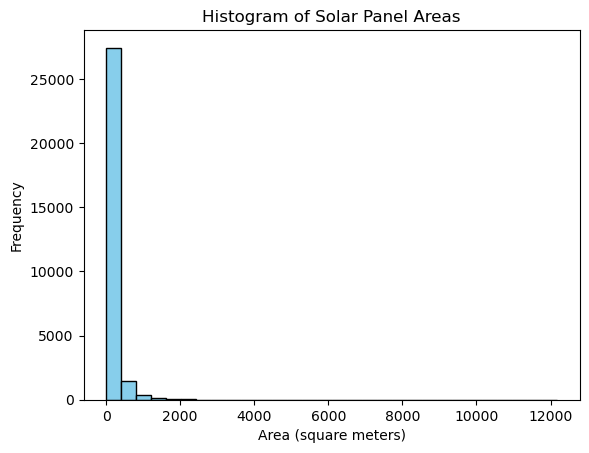

In [ ]:
areas=[]
# Method to find area:

# To calculate the area of each solar panel,we have the info regarding each solar panel in the yolo format, which are normalised values so
# I just multiplied the x-width* y-width*pixel_size*imgae_resolution 
# pixel size is 31cm and image resolution is 416*416 for native resolution.


for file in os.listdir(labels_folder):
    label_path=os.path.join(labels_folder, file)
    with open(label_path, 'r') as file:
            for line in file:
                values = line.strip().split()
                x_width = float(values[3])*(0.31)*416
                y_width = float(values[4])*(0.31)*416

                area = x_width * y_width 
                areas.append(area)
areas=np.array(areas)
mean_area=np.mean(areas)
std_area=np.std(areas)

print(f"Mean area: {mean_area:.2f} square meters")
print(f"Standard deviation of area: {std_area:.2f} square meters")

#histogram of areas
plt.hist(areas, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Solar Panel Areas')

plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.show()

# Observation on area of solar panels:

The mean is 192.52 sq meters and std deviation is 630.7 sq meter, this means that there some instances of solar panels are signinficantly bigger than the average resulting in such std deviation

In [ ]:
from shapely import Polygon
# Convert YOLO format (x_center, y_center, width, height) to bounding box coordinates (min_x, min_y, max_x, max_y)
def yolo_to_bbox(yolo_format):
    
    # (x_center, y_center, width, height) to bounding box coordinates (min_x, min_y, max_x, max_y).
    
    x_center, y_center, width, height = yolo_format
    
    #as we are calculating IoU, which is a ratio so we need not multiply by img_width and img_height(and by 31cm)
    
    min_x=(x_center - width / 2) 
    min_y=(y_center - height / 2) 
    max_x=(x_center + width / 2) 
    max_y=(y_center + height / 2) 
    
    return [min_x, min_y, max_x, max_y]

def calculate_iou(box1, box2):
    bbox1 = yolo_to_bbox(box1)
    bbox2 = yolo_to_bbox(box2)

    # polygons from bounding boxes using Shapely
    polygon1 = Polygon([(bbox1[0], bbox1[1]), (bbox1[2], bbox1[1]), (bbox1[2], bbox1[3]), (bbox1[0], bbox1[3])])
    polygon2 = Polygon([(bbox2[0], bbox2[1]), (bbox2[2], bbox2[1]), (bbox2[2], bbox2[3]), (bbox2[0], bbox2[3])])
    
    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area
    
    # Calculate and return IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

box1 = [0.5, 0.5, 0.4, 0.4]  # Example 
box2 = [0.6, 0.6, 0.3, 0.3]  
print("IoU using the above written function: ",calculate_iou(box1,box2))
box1 = np.array([yolo_to_bbox([0.5, 0.5, 0.4, 0.4])])   
box2 = np.array([yolo_to_bbox([0.6, 0.6, 0.3, 0.3])])
iou_matrix = sv.detection.utils.box_iou_batch(box1, box2)

print("IoU using Supervision:", iou_matrix[0, 0])


IoU using the above written function:  0.3333333333333333
IoU using Supervision: 0.3333333333333333


# Observation
We are getting the IoU ratio same as the one calculated using Supervision library.

# 2. Implementing the Fundamental Functions

Write a function to compute IoU (Intersection over Union) 

Write a function to compute Average Precision (AP)

Use Pascal VOC 11 point interpolation method to implement the function 

Use COCO 101-point interpolation method to implement the function

Use Area under Precision-Recall Curve (AP) method to implement the function 

Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods


In [ ]:

def compute_precision_recall_at_thresholds(confidences, ground_truths, predictions, iou_threshold, conf_threshold):
    precision = []
    recall = []
    
    sorted_indices = np.argsort(confidences)[::-1]
    
    # counters
    true_positives = 0
    false_positives = 0
    false_negatives = len(ground_truths)
    
    # Iterate over sorted predictions and compute precision/recall
    for idx in sorted_indices:
        confidence = confidences[idx]
        
        # ignore predictions below threshold
        if confidence < conf_threshold:
            continue
        
        predicted_box = predictions[idx]
        ground_truth = ground_truths[idx]
        
        # Check if the predicted box has sufficient IoU with ground truth
        if calculate_iou(predicted_box, ground_truth) >= iou_threshold:
            true_positives += 1
            false_negatives -= 1
        else:
            false_positives += 1
        
        # Calculate precision and recall
        precision.append(true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0)
        recall.append(true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0)

    return precision, recall

#  Pascal VOC 11-point interpolation
def voc_11_point_interpolation(precision, recall):
    recall_levels = np.linspace(0, 1, 11)  
    interpolated_precision = []

    for recall_level in recall_levels:
        idx = np.where(recall >= recall_level)[0]
        if len(idx) > 0:
            interpolated_precision.append(max(precision[idx[0]:]))
        else:
            interpolated_precision.append(0)
    
    # Compute average precision over 11 points
    ap = np.mean(interpolated_precision)
    return ap

# COCO 101-point interpolation
def coco_101_point_interpolation(precision, recall):
    recall_levels = np.linspace(0, 1, 101)  # 101 points from recall=0 to recall=1
    interpolated_precision = []

    for recall_level in recall_levels:
        idx = np.where(recall >= recall_level)[0]
        if len(idx) > 0:
            interpolated_precision.append(max(precision[idx[0]:]))
        else:
            interpolated_precision.append(0)
    
    # Compute average precision over 101 points
    ap = np.mean(interpolated_precision)
    return ap

# AP as Area under the Precision-Recall Curve
def ap_auc(precision, recall):
    return np.trapz(precision, recall)

num_images = 10
image_size = 100
box_size = 20
#random examples
ground_truths = np.array([[30, 30, 50, 50], [35, 35, 55, 55], [40, 40, 60, 60], [45, 45, 65, 65],
                          [20, 20, 40, 40], [10, 10, 30, 30], [50, 50, 70, 70], [60, 60, 80, 80],
                          [70, 70, 90, 90], [80, 80, 100, 100]])

predictions = np.array([[32, 32, 52, 52], [36, 36, 56, 56], [42, 42, 62, 62], [46, 46, 66, 66],
                         [25, 25, 45, 45], [15, 15, 35, 35], [52, 52, 72, 72], [65, 65, 85, 85],
                         [75, 75, 95, 95], [85, 85, 105, 105]])

# Random confidence scores between 0 and 1, assuming the model is confident
confidences = np.random.rand(num_images)

# Compute precision and recall with confidence threshold of 0.5
precision, recall = compute_precision_recall_at_thresholds(confidences, ground_truths, predictions,iou_threshold=0.5, conf_threshold=0.5)

ap_voc = voc_11_point_interpolation(precision, recall)
print(f"AP (Pascal VOC 11-point interpolation): {ap_voc:.4f}")

ap_coco = coco_101_point_interpolation(precision, recall)
print(f"AP (COCO 101-point interpolation): {ap_coco:.4f}")

ap_auc_value = ap_auc(precision, recall)
print(f"AP (Area under Precision-Recall Curve): {ap_auc_value:.4f}")

AP (Pascal VOC 11-point interpolation): 0.5455
AP (COCO 101-point interpolation): 0.5050
AP (Area under Precision-Recall Curve): 0.4000


# Model building and evaluation 

In [10]:
#some of the images dont have labels so they can be deleted as they dont give us any usefull information
#we can find the images with no labels from the dictionary created containing number of labels per each file

image_folder = r"C:\Users\Eshwar\Desktop\Course files\AI for sustainability\image_chips_native"
labels_folder = r"C:\Users\Eshwar\Desktop\Course files\AI for sustainability\labels\labels_native"

for f in os.listdir(image_folder):
    label_file = os.path.splitext(f)[0] + '.txt'
    label_path = os.path.join(labels_folder, label_file)
    image_path = os.path.join(image_folder, f)  # Full image path

    if not os.path.exists(label_path):  # If no corresponding label exists
        os.remove(image_path)  # Delete the image
        print(f"Deleted: {image_path}")


In [15]:
print(len(os.listdir(image_folder)))

print(len(os.listdir(labels_folder)))


2542
2542


In [17]:
import random
import shutil
from sklearn.model_selection import train_test_split

train_files,test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

# Create folders for train, val, test
train_img_folder = 'train/images'
val_img_folder = 'val/images'
test_img_folder = 'test/images'

train_lbl_folder = 'train/labels'
val_lbl_folder = 'val/labels'
test_lbl_folder = 'test/labels'

def copy_files(files, img_folder, lbl_folder):
    for file in files:
        img_src = os.path.join(image_folder, file)
        lbl_src = os.path.join(labels_folder, os.path.splitext(file)[0] + '.txt')
        shutil.copy(img_src, img_folder)
        if os.path.exists(lbl_src):
            shutil.copy(lbl_src, lbl_folder)

os.makedirs(train_img_folder, exist_ok=True)
os.makedirs(train_lbl_folder, exist_ok=True)
os.makedirs(val_img_folder, exist_ok=True)
os.makedirs(val_lbl_folder, exist_ok=True)
os.makedirs(test_img_folder, exist_ok=True)
os.makedirs(test_lbl_folder, exist_ok=True)

copy_files(train_files, train_img_folder, train_lbl_folder)
copy_files(val_files, val_img_folder, val_lbl_folder)
copy_files(test_files, test_img_folder, test_lbl_folder)

In [18]:
print(len(os.listdir("train/images")))
print(len(os.listdir("test/images")))
print(len(os.listdir("val/images")))


1829
509
204


In [ ]:
#training the model
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  

model.train(
    data="data.yaml",  
    epochs=20,       
    batch=32,          
    imgsz=416,         
    val=True,          
    save=True,         
)


Ultralytics 8.3.78  Python-3.9.21 torch-2.5.1 CPU (13th Gen Intel Core(TM) i9-13900H)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

train: Scanning C:\Users\Eshwar\Desktop\Course files\AI for sustainability\train\labels.cache... 1829 images, 0 backgrounds, 171 corrupt: 100%|██████████| 1829/1829 [00:00<?, ?it/s]

train: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\train\images\solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\train\images\solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\train\images\solarpanels_native_1__x0_0_y0_7249_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\train\images\solarpanels_native_1__x0_128_y0_7056_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING  C:\Users\Eshwa


val: Scanning C:\Users\Eshwar\Desktop\Course files\AI for sustainability\val\labels.cache... 204 images, 0 backgrounds, 25 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]

val: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\val\images\solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\val\images\solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\val\images\solarpanels_native_1__x0_1536_y0_10086_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING  C:\Users\Eshwar\Desktop\Course files\AI for sustainability\val\images\solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING  C:\Users\Eshwar\Desktop\Cou

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.924      2.128      1.335        311        416: 100%|██████████| 52/52 [05:15<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]

                   all        179       2141      0.864      0.182      0.403      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.519      1.129      1.124        507        416: 100%|██████████| 52/52 [03:42<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.76s/it]

                   all        179       2141      0.565      0.565      0.456       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.456      1.029      1.106        436        416: 100%|██████████| 52/52 [03:53<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]

                   all        179       2141      0.699      0.642      0.699      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G       1.42     0.9814      1.099        525        416: 100%|██████████| 52/52 [04:33<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.25s/it]

                   all        179       2141      0.719      0.686      0.716      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.339     0.8966      1.061        396        416: 100%|██████████| 52/52 [03:40<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.89s/it]

                   all        179       2141      0.802      0.737      0.821      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.287     0.8471      1.045        346        416: 100%|██████████| 52/52 [03:39<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.72s/it]

                   all        179       2141      0.792      0.723      0.793      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.227     0.7845      1.026        502        416: 100%|██████████| 52/52 [09:53<00:00, 11.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.07s/it]

                   all        179       2141      0.812      0.766      0.847      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.243     0.7989      1.026        615        416: 100%|██████████| 52/52 [06:44<00:00,  7.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

                   all        179       2141      0.812      0.781      0.853      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.198     0.7606      1.011        394        416: 100%|██████████| 52/52 [02:17<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]

                   all        179       2141      0.849      0.803      0.875      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.187     0.7367      1.006        378        416: 100%|██████████| 52/52 [02:28<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]

                   all        179       2141      0.869      0.823      0.901      0.624


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.096     0.6936     0.9858        348        416: 100%|██████████| 52/52 [36:31<00:00, 42.15s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

                   all        179       2141      0.866      0.834      0.899      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.086     0.6698     0.9788        348        416: 100%|██████████| 52/52 [02:10<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]

                   all        179       2141      0.892      0.849      0.917      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.062      0.654     0.9723        319        416: 100%|██████████| 52/52 [09:09<00:00, 10.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.96s/it]

                   all        179       2141      0.874      0.847      0.905      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.025     0.6208     0.9599        318        416: 100%|██████████| 52/52 [05:15<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]

                   all        179       2141      0.905      0.845      0.918      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.018      0.612     0.9502        262        416: 100%|██████████| 52/52 [02:13<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]

                   all        179       2141      0.919      0.863      0.935      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.9732     0.5836     0.9428        181        416: 100%|██████████| 52/52 [40:58<00:00, 47.28s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:27<00:00,  9.04s/it]

                   all        179       2141      0.917      0.871      0.937      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.9518     0.5708     0.9375        174        416: 100%|██████████| 52/52 [19:47<00:00, 22.83s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:27<00:00,  9.30s/it]

                   all        179       2141      0.925      0.858      0.938      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.9448     0.5643     0.9322        345        416: 100%|██████████| 52/52 [14:30<00:00, 16.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.92s/it]

                   all        179       2141      0.918      0.884      0.942      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.9175     0.5467     0.9233        418        416: 100%|██████████| 52/52 [25:40<00:00, 29.62s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.96s/it]

                   all        179       2141      0.919       0.88      0.944      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.9118     0.5422     0.9164        298        416: 100%|██████████| 52/52 [09:37<00:00, 11.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.82s/it]

                   all        179       2141      0.929      0.891      0.949      0.716



20 epochs completed in 3.622 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.2MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.78  Python-3.9.21 torch-2.5.1 CPU (13th Gen Intel Core(TM) i9-13900H)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


                   all        179       2141       0.93       0.89      0.949      0.716
Speed: 2.3ms preprocess, 69.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002AB1A627400>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

Loss is Converging, mean average precision and recall is increasing

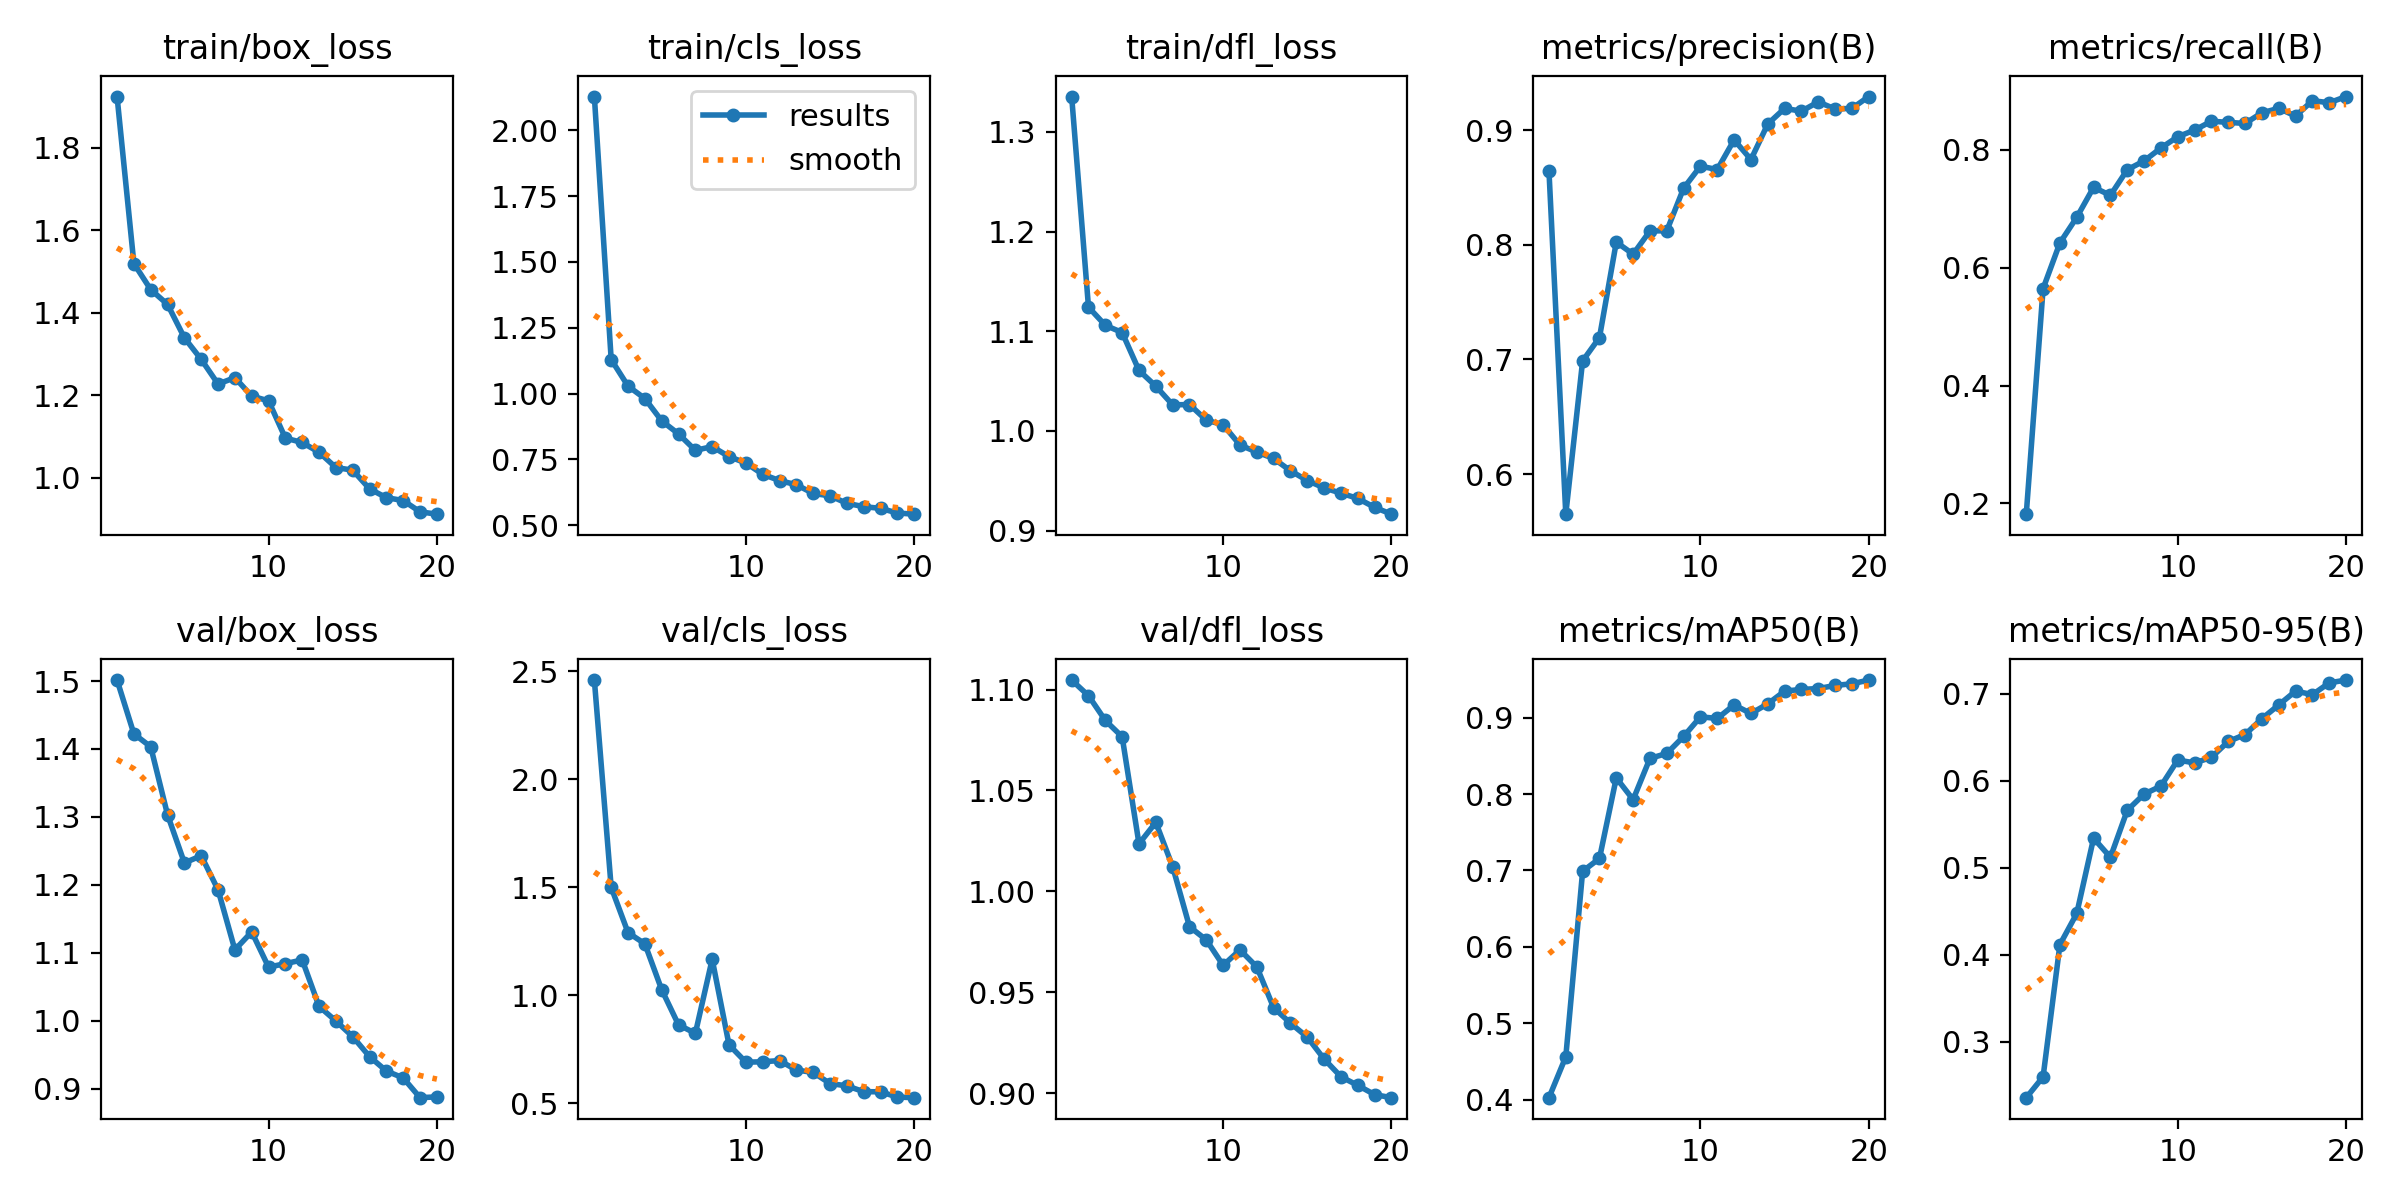

In [29]:
from IPython.display import display
from PIL import Image

image_path = r"runs\detect\train6\results.png"

image = Image.open(image_path)
display(image)

Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 


image 1/1 c:\Users\Eshwar\Desktop\Course files\AI for sustainability\test\images\solarpanels_native_1__x0_6815_y0_12404_dxdy_416.tif: 416x416 33 solar_panels, 205.9ms
Speed: 5.9ms preprocess, 205.9ms inference, 10.8ms postprocess per image at shape (1, 3, 416, 416)


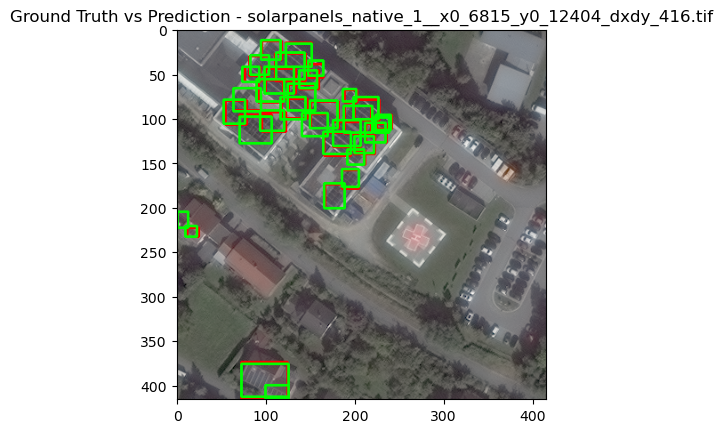


image 1/1 c:\Users\Eshwar\Desktop\Course files\AI for sustainability\test\images\solarpanels_native_1__x0_9848_y0_10589_dxdy_416.tif: 416x416 15 solar_panels, 165.5ms
Speed: 1.7ms preprocess, 165.5ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 416)


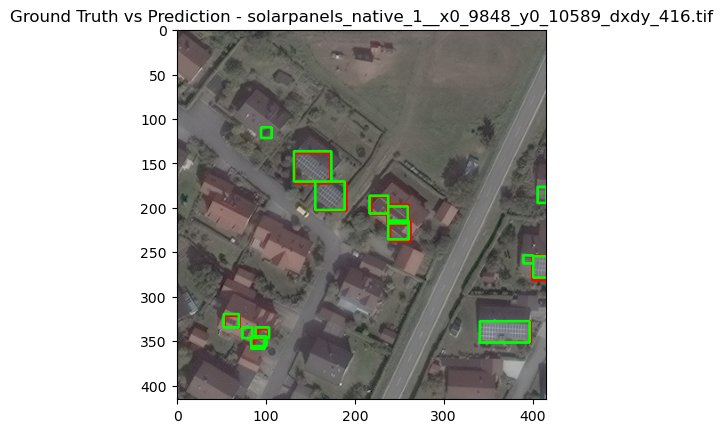


image 1/1 c:\Users\Eshwar\Desktop\Course files\AI for sustainability\test\images\solarpanels_native_2__x0_770_y0_10677_dxdy_416.tif: 416x416 61 solar_panels, 105.2ms
Speed: 1.5ms preprocess, 105.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


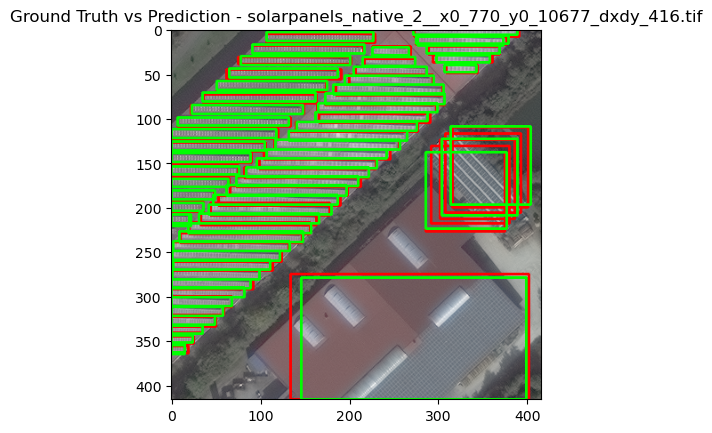


image 1/1 c:\Users\Eshwar\Desktop\Course files\AI for sustainability\test\images\solarpanels_native_2__x0_2733_y0_5068_dxdy_416.tif: 416x416 55 solar_panels, 166.2ms
Speed: 1.5ms preprocess, 166.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


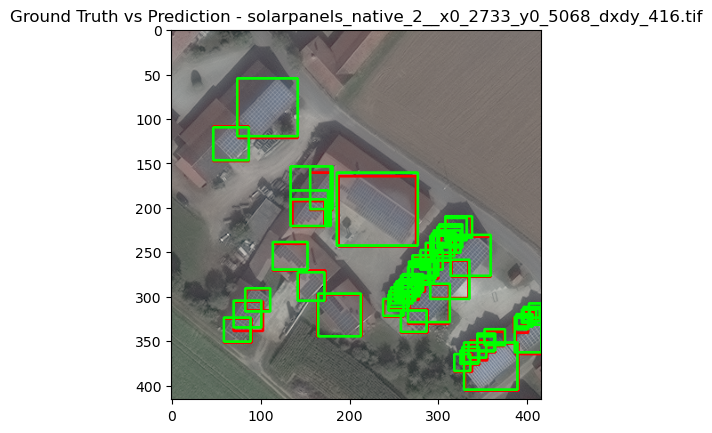

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO(r"runs\detect\train6\weights\best.pt")  

random_test_images = random.sample(test_files, 4)

# Visualize results
for img_name in random_test_images:
    img_path = os.path.join(test_img_folder, img_name)
    label_path = os.path.join(test_lbl_folder, os.path.splitext(img_name)[0] + '.txt')

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    #ground truth
    with open(label_path, 'r') as f:
        gt_boxes = [line.strip().split() for line in f.readlines()]

    # Visualize ground truth bounding boxes
    for gt in gt_boxes:
        x_center, y_center, x_width, y_width = map(float, gt[1:])
        x_min=int((x_center - x_width / 2) * 416)
        y_min=int((y_center - y_width / 2) * 416)
        x_max=int((x_center + x_width / 2) * 416)
        y_max=int((y_center + y_width / 2) * 416)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blue for ground truth

    #prediction
    results = model(img_path)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy()

    # Visualize predicted bounding boxes
    for pred in pred_boxes:
        x_min, y_min, x_max, y_max = map(int, pred)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green for prediction

    plt.imshow(img)
    plt.title(f"Ground Truth vs Prediction - {img_name}")
    plt.show()


converting images from .tif to .jpg as supervision is not responding to .tif images

In [ ]:
from PIL import Image
import os
import shutil

for split in ["train", "test", "val"]:
    input_folder=os.path.join(split, "images")
    output_folder=os.path.join(f"{split}_jpg", "images")
    labels_input=os.path.join(split, "labels")
    labels_output=os.path.join(f"{split}_jpg", "labels")

    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(labels_output, exist_ok=True)

    for file in os.listdir(input_folder):
        img=Image.open(os.path.join(input_folder, file))
        img.convert("RGB").save(os.path.join(output_folder, file.replace(".tif", ".jpg")), "JPEG", quality=100)

    for file in os.listdir(labels_input):
        shutil.copy(os.path.join(labels_input, file), os.path.join(labels_output, file))

print("Conversion and label copying complete.")


Conversion and label copying complete.


In [ ]:
import numpy as np
import os
import supervision as sv
from ultralytics import YOLO

# Load YOLO model
model = YOLO(r"runs\detect\train6\weights\best.pt") 

# Define test dataset paths
test_img_folder = r"test_jpg\images"
test_lbl_folder = r"test_jpg\labels"

# Load test dataset in supervision format
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=test_img_folder,
    annotations_directory_path=test_lbl_folder,
    data_yaml_path=r"data.yaml"  
)   

def callback(image: np.ndarray) -> sv.Detections:
    result = model(image)[0]
    return sv.Detections.from_ultralytics(result)

# Compute mAP50 using supervision
mean_average_precision = sv.MeanAveragePrecision.benchmark(
    dataset=dataset,
    callback=callback
)

print(f"mAP50: {mean_average_precision.map50:.4f}")  



0: 416x416 9 solar_panels, 90.6ms
Speed: 3.8ms preprocess, 90.6ms inference, 8.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 solar_panels, 40.3ms
Speed: 0.8ms preprocess, 40.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 4 solar_panels, 38.4ms
Speed: 0.8ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 8 solar_panels, 41.0ms
Speed: 0.8ms preprocess, 41.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 10 solar_panels, 40.9ms
Speed: 0.7ms preprocess, 40.9ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 11 solar_panels, 39.2ms
Speed: 0.8ms preprocess, 39.2ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 11 solar_panels, 39.7ms
Speed: 1.8ms preprocess, 39.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 10 solar_panels, 42.1ms
Speed: 0.7ms preprocess, 42.1ms infer

In [ ]:
import numpy as np
import pandas as pd

# Define IoU and Confidence thresholds
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

confusion_matrices = {}  

for iou in iou_thresholds:
    for conf in conf_thresholds:
        cm = sv.ConfusionMatrix.benchmark(
          dataset=dataset,
          callback=callback,
          conf_threshold=conf,
          iou_threshold=iou
        )
        confusion_matrices[(iou, conf)] = cm

iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Initialize tables
precision_table = np.zeros((len(iou_thresholds), len(conf_thresholds)))
recall_table = np.zeros((len(iou_thresholds), len(conf_thresholds)))
f1_table = np.zeros((len(iou_thresholds), len(conf_thresholds)))

# Iterate over IoU and confidence thresholds
for i, iou in enumerate(iou_thresholds):
    for j, conf in enumerate(conf_thresholds):
        # Get confusion matrix for (iou, conf)
        confusion_matrix = confusion_matrices[(iou, conf)].matrix  

        # Extract relevant values for class 0 (solarpanel0 is dominant)
        TP = confusion_matrix[0, 0]  # True Positives for solarpanel0
        FP = confusion_matrix[:, 0].sum() - TP  # False Positives for solarpanel0
        FN = confusion_matrix[0, :].sum() - TP  # False Negatives for solarpanel0

        # Compute metrics
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Store values
        precision_table[i, j] = precision
        recall_table[i, j] = recall
        f1_table[i, j] = f1_score

precision_df = pd.DataFrame(precision_table, index=iou_thresholds, columns=conf_thresholds)
recall_df = pd.DataFrame(recall_table, index=iou_thresholds, columns=conf_thresholds)
f1_df = pd.DataFrame(f1_table, index=iou_thresholds, columns=conf_thresholds)

# Print tables
print("\nPrecision Table:")
print(precision_df)

print("\nRecall Table:")
print(recall_df)

print("\nF1-Score Table:")
print(f1_df)


0: 416x416 9 solar_panels, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 solar_panels, 62.8ms
Speed: 1.0ms preprocess, 62.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 4 solar_panels, 61.1ms
Speed: 1.4ms preprocess, 61.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 8 solar_panels, 78.5ms
Speed: 1.4ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 10 solar_panels, 60.5ms
Speed: 1.3ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 11 solar_panels, 61.8ms
Speed: 1.1ms preprocess, 61.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 11 solar_panels, 61.1ms
Speed: 1.4ms preprocess, 61.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 10 solar_panels, 59.2ms
Speed: 1.3ms preprocess, 59.2ms inf

Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1) 


In [ ]:
display(precision_df)
# Rows are IoU thresholds
# Columns are confidence thresholds

0.1       0.3       0.5       0.7       0.9
0.1  0.791778  0.824671  0.932511  0.983020  0.998907
0.3  0.789991  0.823262  0.931576  0.982506  0.998907
0.5  0.778969  0.811835  0.922976  0.977103  0.996721
0.7  0.721180  0.753601  0.863900  0.953435  0.996721
0.9  0.302204  0.317157  0.376332  0.485722  0.901639

In [24]:
display(recall_df)
# Rows are IoU thresholds
# Columns are confidence thresholds

0.1       0.3       0.5       0.7       0.9
0.1  0.942052  0.933546  0.883927  0.677122  0.161971
0.3  0.939926  0.931951  0.883041  0.676768  0.161971
0.5  0.926812  0.919015  0.874889  0.673046  0.161616
0.7  0.858054  0.853092  0.818891  0.656743  0.161616
0.9  0.359561  0.359029  0.356725  0.334574  0.146199

In [25]:
display(f1_df)
# Rows are IoU thresholds
# Columns are confidence thresholds

0.1       0.3       0.5       0.7       0.9
0.1  0.860403  0.875738  0.907569  0.801889  0.278744
0.3  0.858461  0.874242  0.906659  0.801469  0.278744
0.5  0.846484  0.862106  0.898290  0.797062  0.278134
0.7  0.783685  0.800266  0.840793  0.777754  0.278134
0.9  0.328397  0.336797  0.366266  0.396222  0.251601